In [12]:
import pandas as pd
import numpy as np
from scipy.stats import tmean
import dautil as dl
from scipy.stats import iqr,kurtosis,skew
from statistics import mode
from scipy.fftpack import fft, fftfreq
from scipy import signal
from scipy import stats
from scipy.signal import butter, filtfilt, lfilter
from sklearn.linear_model import LinearRegression

In [2]:
train_df = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

#### C. Benchmark Model:

In [288]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [4]:
nsample = 150_090
sampling=4e6
dt = 1.0 / sampling
T = nsample * dt

# Ref. https://books.google.jo/books?id=nZWqDQAAQBAJ&pg=PA109&lpg=PA109&dq=IQM+python&source=bl&ots=7t0Zof3DwM&sig=ACfU3U34jWFxFitcRCNM_ga-N0wyH28d8A&hl=en&sa=X&ved=2ahUKEwiwwLDK_ZThAhVKWxoKHSyLAkwQ6AEwBHoECAgQAQ#v=onepage&q=IQM%20python&f=false
def truncated_mean(a, percentile):
    limits = dl.stats.outliers(a, method='percentiles', percentiles=(percentile, 100 - percentile))
    return tmean(a, limits=limits)

# Ref. https://books.google.jo/books?id=nZWqDQAAQBAJ&pg=PA109&lpg=PA109&dq=IQM+python&source=bl&ots=7t0Zof3DwM&sig=ACfU3U34jWFxFitcRCNM_ga-N0wyH28d8A&hl=en&sa=X&ved=2ahUKEwiwwLDK_ZThAhVKWxoKHSyLAkwQ6AEwBHoECAgQAQ#v=onepage&q=IQM%20python&f=false
def iqm(x):
    return truncated_mean(x, 25)

# Low_pass filter - Ref.https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Band_pass filter - Ref. https://stackoverflow.com/questions/48101564/create-a-band-pass-filter-via-scipy-in-python

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
# original: 

    train_seg_lowp = pd.Series(butter_lowpass_filter(xc, 125_000, 4e6, order=5))
    train_seg_band1 = pd.Series(butter_bandpass_filter(xc, 125_000-35_000, 250_000, 4e6, order=5))
    train_seg_band2 = pd.Series(butter_bandpass_filter(xc, 250_000-35_000, 375_000, 4e6, order=5))
    train_seg_band3 = pd.Series(butter_bandpass_filter(xc, 375_000-35_000, 500_000, 4e6, order=5))
    train_seg_band4 = pd.Series(butter_bandpass_filter(xc, 500_000-65_000, 750_000, 4e6, order=5))    
    train_seg_band5 = pd.Series(butter_bandpass_filter(xc, 750_000-65_000, 1_000_000, 4e6, order=5))
    train_seg_band6 = pd.Series(butter_bandpass_filter(xc, 1_000_000-65_000, 1_250_000, 4e6, order=5))  
    train_seg_band7 = pd.Series(butter_bandpass_filter(xc, 1_250_000-35_000, 1_375_000, 4e6, order=5))
    train_seg_band8 = pd.Series(butter_bandpass_filter(xc, 1_375_000-35_000, 1_500_000, 4e6, order=5))
    train_seg_band9 = pd.Series(butter_bandpass_filter(xc, 1_500_000-35_000, 1_625_000, 4e6, order=5))
    train_seg_band10 = pd.Series(butter_bandpass_filter(xc, 1_625_000-35_000, 1_900_000, 4e6, order=5))
    
# modified 1:

    train_seg_lowp = pd.Series(butter_lowpass_filter(xc, 60_000, 4e6, order=5))
    train_seg_band1 = pd.Series(butter_bandpass_filter(xc, 60_000-20_000, 125_000, 4e6, order=5))
    train_seg_band2 = pd.Series(butter_bandpass_filter(xc, 125_000-35_000, 250_000, 4e6, order=5))  
    train_seg_band3 = pd.Series(butter_bandpass_filter(xc, 250_000-35_000, 310_000, 4e6, order=5))
    train_seg_band4 = pd.Series(butter_bandpass_filter(xc, 310_000-35_000, 375_000, 4e6, order=5))
    train_seg_band5 = pd.Series(butter_bandpass_filter(xc, 375_000-35_000, 435_000, 4e6, order=5))
    train_seg_band6 = pd.Series(butter_bandpass_filter(xc, 435_000-35_000, 500_000, 4e6, order=5))
    train_seg_band7 = pd.Series(butter_bandpass_filter(xc, 500_000-65_000, 1_375_000, 4e6, order=5))    
    train_seg_band8 = pd.Series(butter_bandpass_filter(xc, 1_375_000-35_000, 1_500_000, 4e6, order=5))
    train_seg_band9 = pd.Series(butter_bandpass_filter(xc, 1_500_000-35_000, 1_560_000, 4e6, order=5))
    train_seg_band10 = pd.Series(butter_bandpass_filter(xc, 1_560_000-35_000, 1_625_000, 4e6, order=5))
    train_seg_band11 = pd.Series(butter_bandpass_filter(xc, 1_625_000-35_000, 1_900_000, 4e6, order=5))


#### Overlapping segments: 

In [5]:
def create_features_bpass3(seg_id, seg, X):
    
    xc = pd.Series(seg['acoustic_data'].values)
    
    train_seg_lowp = pd.Series(butter_lowpass_filter(xc, 60_000, 4e6, order=5))
    train_seg_band1 = pd.Series(butter_bandpass_filter(xc, 60_000-20_000, 125_000, 4e6, order=5))
    train_seg_band2 = pd.Series(butter_bandpass_filter(xc, 125_000-35_000, 250_000, 4e6, order=5))  
    train_seg_band3 = pd.Series(butter_bandpass_filter(xc, 250_000-35_000, 310_000, 4e6, order=5))
    train_seg_band4 = pd.Series(butter_bandpass_filter(xc, 310_000-35_000, 375_000, 4e6, order=5))
    train_seg_band5 = pd.Series(butter_bandpass_filter(xc, 375_000-35_000, 435_000, 4e6, order=5))
    train_seg_band6 = pd.Series(butter_bandpass_filter(xc, 435_000-35_000, 500_000, 4e6, order=5))
    train_seg_band7 = pd.Series(butter_bandpass_filter(xc, 500_000-65_000, 1_375_000, 4e6, order=5))    
    train_seg_band8 = pd.Series(butter_bandpass_filter(xc, 1_375_000-35_000, 1_500_000, 4e6, order=5))
    train_seg_band9 = pd.Series(butter_bandpass_filter(xc, 1_500_000-35_000, 1_560_000, 4e6, order=5))
    train_seg_band10 = pd.Series(butter_bandpass_filter(xc, 1_560_000-35_000, 1_625_000, 4e6, order=5))
    train_seg_band11 = pd.Series(butter_bandpass_filter(xc, 1_625_000-35_000, 1_900_000, 4e6, order=5))

# Common measures of location:    
    
    X.loc[seg_id, 'mean_lowp'] = train_seg_lowp.mean()
    X.loc[seg_id, 'mean_band_1'] = train_seg_band1.mean()    
    X.loc[seg_id, 'mean_band_2'] = train_seg_band2.mean()
    X.loc[seg_id, 'mean_band_3'] = train_seg_band3.mean()    
    X.loc[seg_id, 'mean_band_4'] = train_seg_band4.mean()    
    X.loc[seg_id, 'mean_band_5'] = train_seg_band5.mean()
    X.loc[seg_id, 'mean_band_6'] = train_seg_band6.mean()    
    X.loc[seg_id, 'mean_band_7'] = train_seg_band7.mean()  
    X.loc[seg_id, 'mean_band_8'] = train_seg_band8.mean()  
    X.loc[seg_id, 'mean_band_9'] = train_seg_band9.mean()  
    X.loc[seg_id, 'mean_band_10'] = train_seg_band10.mean()  
    X.loc[seg_id, 'mean_band_11'] = train_seg_band11.mean() 
    
    X.loc[seg_id, 'median_lowp'] = train_seg_lowp.median()   
    X.loc[seg_id, 'median_band_1'] = train_seg_band1.median()       
    X.loc[seg_id, 'median_band_2'] = train_seg_band2.median()   
    X.loc[seg_id, 'median_band_3'] = train_seg_band3.median()     
    X.loc[seg_id, 'median_band_4'] = train_seg_band4.median()      
    X.loc[seg_id, 'median_band_5'] = train_seg_band5.median()  
    X.loc[seg_id, 'median_band_6'] = train_seg_band6.median()
    X.loc[seg_id, 'median_band_7'] = train_seg_band7.median()  
    X.loc[seg_id, 'median_band_8'] = train_seg_band8.median()  
    X.loc[seg_id, 'median_band_9'] = train_seg_band9.median()  
    X.loc[seg_id, 'median_band_10'] = train_seg_band10.median()  
    X.loc[seg_id, 'median_band_11'] = train_seg_band11.median()  
    
    X.loc[seg_id, 'iqm_lowp'] = iqm(train_seg_lowp)
    X.loc[seg_id, 'iqm_band_1'] = iqm(train_seg_band1)
    X.loc[seg_id, 'iqm_band_2'] = iqm(train_seg_band2)
    X.loc[seg_id, 'iqm_band_3'] = iqm(train_seg_band3)
    X.loc[seg_id, 'iqm_band_4'] = iqm(train_seg_band4)  
    X.loc[seg_id, 'iqm_band_5'] = iqm(train_seg_band5)
    X.loc[seg_id, 'iqm_band_6'] = iqm(train_seg_band6) 
    X.loc[seg_id, 'iqm_band_7'] = iqm(train_seg_band7)
    X.loc[seg_id, 'iqm_band_8'] = iqm(train_seg_band8)
    X.loc[seg_id, 'iqm_band_9'] = iqm(train_seg_band9)
    X.loc[seg_id, 'iqm_band_10'] = iqm(train_seg_band10)
    X.loc[seg_id, 'iqm_band_11'] = iqm(train_seg_band11)
    
#Common measures of statistical dispersion:

    X.loc[seg_id, 'std_lowp'] = train_seg_lowp.std()
    X.loc[seg_id, 'std_band1'] = train_seg_band1.std()    
    X.loc[seg_id, 'std_band2'] = train_seg_band2.std()    
    X.loc[seg_id, 'std_band3'] = train_seg_band3.std()
    X.loc[seg_id, 'std_band4'] = train_seg_band4.std()    
    X.loc[seg_id, 'std_band5'] = train_seg_band5.std()    
    X.loc[seg_id, 'std_band6'] = train_seg_band6.std()
    X.loc[seg_id, 'std_band7'] = train_seg_band7.std()
    X.loc[seg_id, 'std_band8'] = train_seg_band8.std()
    X.loc[seg_id, 'std_band9'] = train_seg_band9.std()
    X.loc[seg_id, 'std_band10'] = train_seg_band10.std()
    X.loc[seg_id, 'std_band11'] = train_seg_band11.std()
 
    X.loc[seg_id, 'var_lowp'] = train_seg_lowp.var()
    X.loc[seg_id, 'var_band1'] = train_seg_band1.var()    
    X.loc[seg_id, 'var_band2'] = train_seg_band2.var()    
    X.loc[seg_id, 'var_band3'] = train_seg_band3.var()   
    X.loc[seg_id, 'var_band4'] = train_seg_band4.var()       
    X.loc[seg_id, 'var_band5'] = train_seg_band5.var()    
    X.loc[seg_id, 'var_band6'] = train_seg_band6.var()
    X.loc[seg_id, 'var_band7'] = train_seg_band7.var()
    X.loc[seg_id, 'var_band8'] = train_seg_band8.var()
    X.loc[seg_id, 'var_band9'] = train_seg_band9.var()
    X.loc[seg_id, 'var_band10'] = train_seg_band10.var()
    X.loc[seg_id, 'var_band11'] = train_seg_band11.var()
    
    X.loc[seg_id, 'range_lowp'] = train_seg_lowp.ptp()
    X.loc[seg_id, 'range_band1'] = train_seg_band1.ptp()    
    X.loc[seg_id, 'range_band2'] = train_seg_band2.ptp()    
    X.loc[seg_id, 'range_band3'] = train_seg_band3.ptp()
    X.loc[seg_id, 'range_band4'] = train_seg_band4.ptp()    
    X.loc[seg_id, 'range_band5'] = train_seg_band5.ptp()
    X.loc[seg_id, 'range_band6'] = train_seg_band6.ptp()
    X.loc[seg_id, 'range_band7'] = train_seg_band7.ptp() 
    X.loc[seg_id, 'range_band8'] = train_seg_band8.ptp() 
    X.loc[seg_id, 'range_band9'] = train_seg_band9.ptp() 
    X.loc[seg_id, 'range_band10'] = train_seg_band10.ptp() 
    X.loc[seg_id, 'range_band11'] = train_seg_band11.ptp() 
    
    X.loc[seg_id, 'iqrange_lowp'] = iqr(train_seg_lowp, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'iqrange_band1'] = iqr(train_seg_band1, rng=(25,75), interpolation='midpoint')     
    X.loc[seg_id, 'iqrange_band2'] = iqr(train_seg_band2, rng=(25,75), interpolation='midpoint')     
    X.loc[seg_id, 'iqrange_band3'] = iqr(train_seg_band3, rng=(25,75), interpolation='midpoint')     
    X.loc[seg_id, 'iqrange_band4'] = iqr(train_seg_band4, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'iqrange_band5'] = iqr(train_seg_band5, rng=(25,75), interpolation='midpoint')     
    X.loc[seg_id, 'iqrange_band6'] = iqr(train_seg_band6, rng=(25,75), interpolation='midpoint')
    X.loc[seg_id, 'iqrange_band7'] = iqr(train_seg_band7, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'iqrange_band8'] = iqr(train_seg_band8, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'iqrange_band9'] = iqr(train_seg_band9, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'iqrange_band10'] = iqr(train_seg_band10, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'iqrange_band11'] = iqr(train_seg_band11, rng=(25,75), interpolation='midpoint') 
    
    X.loc[seg_id, 'mad_lowp'] = train_seg_lowp.mad()   
    X.loc[seg_id, 'mad_band1'] = train_seg_band1.mad()   
    X.loc[seg_id, 'mad_band2'] = train_seg_band2.mad() 
    X.loc[seg_id, 'mad_band3'] = train_seg_band3.mad()
    X.loc[seg_id, 'mad_band4'] = train_seg_band4.mad()
    X.loc[seg_id, 'mad_band5'] = train_seg_band5.mad()
    X.loc[seg_id, 'mad_band6'] = train_seg_band6.mad()
    X.loc[seg_id, 'mad_band7'] = train_seg_band7.mad()
    X.loc[seg_id, 'mad_band8'] = train_seg_band8.mad()
    X.loc[seg_id, 'mad_band9'] = train_seg_band9.mad()
    X.loc[seg_id, 'mad_band10'] = train_seg_band10.mad()
    X.loc[seg_id, 'mad_band11'] = train_seg_band11.mad()

#Common measures of the shape:

    X.loc[seg_id, 'skew_lowp'] = skew(train_seg_lowp)  
    X.loc[seg_id, 'skew_band1'] = skew(train_seg_band1)
    X.loc[seg_id, 'skew_band2'] = skew(train_seg_band2)  
    X.loc[seg_id, 'skew_band3'] = skew(train_seg_band3)  
    X.loc[seg_id, 'skew_band4'] = skew(train_seg_band4) 
    X.loc[seg_id, 'skew_band5'] = skew(train_seg_band5) 
    X.loc[seg_id, 'skew_band6'] = skew(train_seg_band6)  
    X.loc[seg_id, 'skew_band7'] = skew(train_seg_band7) 
    X.loc[seg_id, 'skew_band8'] = skew(train_seg_band8) 
    X.loc[seg_id, 'skew_band9'] = skew(train_seg_band9) 
    X.loc[seg_id, 'skew_band10'] = skew(train_seg_band10) 
    X.loc[seg_id, 'skew_band11'] = skew(train_seg_band11) 
    
    X.loc[seg_id, 'kurtosis_lowp'] = kurtosis(train_seg_lowp)      
    X.loc[seg_id, 'kurtosis_band1'] = kurtosis(train_seg_band1)    
    X.loc[seg_id, 'kurtosis_band2'] = kurtosis(train_seg_band2)    
    X.loc[seg_id, 'kurtosis_band3'] = kurtosis(train_seg_band3) 
    X.loc[seg_id, 'kurtosis_band4'] = kurtosis(train_seg_band4) 
    X.loc[seg_id, 'kurtosis_band5'] = kurtosis(train_seg_band5) 
    X.loc[seg_id, 'kurtosis_band6'] = kurtosis(train_seg_band6) 
    X.loc[seg_id, 'kurtosis_band7'] = kurtosis(train_seg_band7) 
    X.loc[seg_id, 'kurtosis_band8'] = kurtosis(train_seg_band8) 
    X.loc[seg_id, 'kurtosis_band9'] = kurtosis(train_seg_band9) 
    X.loc[seg_id, 'kurtosis_band10'] = kurtosis(train_seg_band10) 
    X.loc[seg_id, 'kurtosis_band11'] = kurtosis(train_seg_band11) 

In [6]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [7]:
from tqdm import tqdm_notebook

for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features_bpass3(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [17]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [18]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features_bpass3(seg_id, seg, test_X)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [20]:
from sklearn.model_selection import KFold

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = train_X.columns.values

In [23]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import seaborn as sns

oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
scores = []
feature_importance_df = pd.DataFrame()
fold_importance = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    y_pred_valid = model.predict(X_val, num_iteration=model.best_iteration_)
    oof[val_idx] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_val, y_pred_valid))

    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits
    
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
feature_importance_df["importance"] /= fold_

cols = feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(
                by="importance", ascending=False)[:70].index

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(30, 30));
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [50]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = predictions
submission.to_csv('submissionbandpass10ovrlp.csv',index=True)

In [160]:
import gc
gc.collect()

11133

In [15]:
import copy
import gc
import os
import sys
import warnings

from IPython.core.display import display, HTML
import lightgbm as lgb
from matplotlib import pyplot as plt
import numba
import numpy as np
import pandas as pd
import pyarrow
import pyarrow.parquet as pq
import scipy.stats
import seaborn as sns 
import sklearn
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support

In [18]:
@numba.jit(nopython=True)
def flatiron(x, alpha=100., beta=1):
    """
    Flatten signal
    
    Creator: Michael Kazachok
    Source: https://www.kaggle.com/miklgr500/flatiron
    """
    new_x = np.zeros_like(x)
    zero = x[0]
    for i in range(1, len(x)):
        zero = zero*(alpha-beta)/alpha + beta*x[i]/alpha
        new_x[i] = x[i] - zero
    return new_x

In [19]:
@numba.jit(nopython=True)
def drop_missing(intersect,sample):
    """
    Find intersection of sorted numpy arrays
    
    Since intersect1d sort arrays each time, it's effectively inefficient.
    Here you have to sweep intersection and each sample together to build
    the new intersection, which can be done in linear time, maintaining order. 

    Source: https://stackoverflow.com/questions/46572308/intersection-of-sorted-numpy-arrays
    Creator: B. M.
    """
    i=j=k=0
    new_intersect=np.empty_like(intersect)
    while i< intersect.size and j < sample.size:
        if intersect[i]==sample[j]: # the 99% case
            new_intersect[k]=intersect[i]
            k+=1
            i+=1
            j+=1
        elif intersect[i]<sample[j]:
            i+=1
        else : 
            j+=1
    return new_intersect[:k]

In [21]:
@numba.jit(nopython=True)
def _local_maxima_1d_window_single_pass(x, w):
    
    midpoints = np.empty(x.shape[0] // 2, dtype=np.intp)
    left_edges = np.empty(x.shape[0] // 2, dtype=np.intp)
    right_edges = np.empty(x.shape[0] // 2, dtype=np.intp)
    m = 0  # Pointer to the end of valid area in allocated arrays

    i = 1  # Pointer to current sample, first one can't be maxima
    i_max = x.shape[0] - 1  # Last sample can't be maxima
    while i < i_max:
        # Test if previous sample is smaller
        if x[i - 1] < x[i]:
            i_ahead = i + 1  # Index to look ahead of current sample

            # Find next sample that is unequal to x[i]
            while i_ahead < i_max and x[i_ahead] == x[i]:
                i_ahead += 1
                    
            i_right = i_ahead - 1
            
            f = False
            i_window_end = i_right + w
            while i_ahead < i_max and i_ahead < i_window_end:
                if x[i_ahead] > x[i]:
                    f = True
                    break
                i_ahead += 1
                
            # Maxima is found if next unequal sample is smaller than x[i]
            if x[i_ahead] < x[i]:
                left_edges[m] = i
                right_edges[m] = i_right
                midpoints[m] = (left_edges[m] + right_edges[m]) // 2
                m += 1
                
            # Skip samples that can't be maximum
            i = i_ahead - 1
        i += 1

    # Keep only valid part of array memory.
    midpoints = midpoints[:m]
    left_edges = left_edges[:m]
    right_edges = right_edges[:m]
    
    return midpoints, left_edges, right_edges

@numba.jit(nopython=True)
def local_maxima_1d_window(x, w=1):
    """
    Find local maxima in a 1D array.
    This function finds all local maxima in a 1D array and returns the indices
    for their midpoints (rounded down for even plateau sizes).
    It is a modified version of scipy.signal._peak_finding_utils._local_maxima_1d
    to include the use of a window to define how many points on each side to use in
    the test for a point being a local maxima.
    Parameters
    ----------
    x : ndarray
        The array to search for local maxima.
    w : np.int
        How many points on each side to use for the comparison to be True
    Returns
    -------
    midpoints : ndarray
        Indices of midpoints of local maxima in `x`.
    Notes
    -----
    - Compared to `argrelmax` this function is significantly faster and can
      detect maxima that are more than one sample wide. However this comes at
      the cost of being only applicable to 1D arrays.
    """    
        
    fm, fl, fr = _local_maxima_1d_window_single_pass(x, w)
    bm, bl, br = _local_maxima_1d_window_single_pass(x[::-1], w)
    bm = np.abs(bm - x.shape[0] + 1)[::-1]
    bl = np.abs(bl - x.shape[0] + 1)[::-1]
    br = np.abs(br - x.shape[0] + 1)[::-1]

    m = drop_missing(fm, bm)

    return m

In [22]:
@numba.jit(nopython=True)
def plateau_detection(grad, threshold, plateau_length=5):
    """Detect the point when the gradient has reach a plateau"""
    
    count = 0
    loc = 0
    for i in range(grad.shape[0]):
        if grad[i] > threshold:
            count += 1
        
        if count == plateau_length:
            loc = i - plateau_length
            break
            
    return loc

In [27]:
#@numba.jit(nopython=True)
def get_peaks(
    x, 
    window=25,
    visualise=False,
    visualise_color=None,
):
    """
    Find the peaks in a signal trace.
    Parameters
    ----------
    x : ndarray
        The array to search.
    window : np.int
        How many points on each side to use for the local maxima test
    Returns
    -------
    peaks_x : ndarray
        Indices of midpoints of peaks in `x`.
    peaks_y : ndarray
        Absolute heights of peaks in `x`.
    x_hp : ndarray
        An absolute flattened version of `x`.
    """
    
    x_hp = flatiron(x, 100, 1)

    x_dn = np.abs(x_hp)
    
    peaks = local_maxima_1d_window(x_dn, window)
    
    heights = x_dn[peaks]
    
    ii = np.argsort(heights)[::-1]
    
    peaks = peaks[ii]
    heights = heights[ii]
    
    ky = heights
    kx = np.arange(1, heights.shape[0]+1)
    
    conv_length = 9

    grad = np.diff(ky, 1)/np.diff(kx, 1)
    grad = np.convolve(grad, np.ones(conv_length)/conv_length)#, mode='valid')
    grad = grad[conv_length-1:-conv_length+1]
    
    knee_x = plateau_detection(grad, -0.01, plateau_length=1000)
    knee_x -= conv_length//2
    
    if visualise:
        plt.plot(grad, color=visualise_color)
        plt.axvline(knee_x, ls="--", color=visualise_color)
    
    peaks_x = peaks[:knee_x]
    peaks_y = heights[:knee_x]
    
    ii = np.argsort(peaks_x)
    peaks_x = peaks_x[ii]
    peaks_y = peaks_y[ii]
        
    return peaks_x, peaks_y, x_hp

In [23]:
@numba.jit(nopython=True)
def clip(v, l, u):
    """Numba helper function to clip a value"""
    
    if v < l:
        v = l
    elif v > u:
        v = u
        
    return v

In [191]:
peak_features_names = [
    'ratio_next',
    'ratio_prev',
    'small_dist_to_min',
    'sawtooth_rmse',
]

num_peak_features = len(peak_features_names)

@numba.jit(nopython=True)
def create_sawtooth_template(sawtooth_length, pre_length, post_length):
    """Generate sawtooth template"""
    
    l = pre_length+post_length+1
    
    st = np.zeros(l)
    for i in range(sawtooth_length+1):
        
        j = pre_length+i
        if j < l:
            st[j] = 1 - ((2./sawtooth_length) * i)
        
    return st

@numba.jit(nopython=True)
def calculate_peak_features(px, x_hp0, ws=5, wl=25):
    """
    Calculate features for peaks.
    Parameters
    ----------
    px : ndarray
        Indices of peaks.
    x_hp0 : ndarray
        The array to search.
    ws : np.int
        How many points on each side to use for small window features
    wl : np.int
        How many points on each side to use for large window features
    Returns
    -------
    features : ndarray
        Features calculate for each peak in `x_hp0`.
    """
    
    features = np.ones((px.shape[0], num_peak_features), dtype=np.float64) * np.nan
    
    for i in range(px.shape[0]):
        
        feature_number = 0
        
        x = px[i]
        x_next = x+1
        x_prev = x-1
        
        h0 = x_hp0[x]

        ws_s = clip(x-ws, 0, 150000-1)
        ws_e = clip(x+ws, 0, 150000-1)
        wl_s = clip(x-wl, 0, 150000-1)
        wl_e = clip(x+wl, 0, 150000-1)
        
        ws_pre = x - ws_s
        ws_post = ws_e - x
        
        wl_pre = x - wl_s
        wl_post = wl_e - x
        
        if x_next < 150000:
            h0_next = x_hp0[x_next]
            features[i, feature_number] = np.abs(h0_next)/np.abs(h0)
        feature_number += 1
            
        if x_prev >= 0:
            h0_prev = x_hp0[x_prev]
            features[i, feature_number] = np.abs(h0_prev)/np.abs(h0)
        feature_number += 1
            
        x_hp_ws0 = x_hp0[ws_s:ws_e+1]
        x_hp_wl0 = x_hp0[wl_s:wl_e+1]
        x_hp_wl0_norm = (x_hp_wl0/np.abs(h0))
        x_hp_ws0_norm = (x_hp_ws0/np.abs(h0))
        x_hp_abs_wl0 = np.abs(x_hp_wl0)
        wl_max_0 = np.max(x_hp_abs_wl0)
        
        ws_opp_peak_i = np.argmin(x_hp_ws0*np.sign(h0))
        
        features[i, feature_number] = ws_opp_peak_i - ws
        feature_number += 1
        
        x_hp_wl0_norm_sign = x_hp_wl0_norm * np.sign(h0)
        
        sawtooth_length = 3
        st = create_sawtooth_template(sawtooth_length, wl_pre, wl_post)
        assert np.argmax(st) == np.argmax(x_hp_wl0_norm_sign)
        assert st.shape[0] == x_hp_wl0_norm_sign.shape[0]
        features[i, feature_number] = np.mean(np.power(x_hp_wl0_norm_sign - st, 2))
        feature_number += 1
        
        if i == 0:
            assert feature_number == num_peak_features
        
    return features

In [192]:
def process_signal(
    data,
    window=25,
):
    """
    Process a signal trace to find the peaks and calculate features for each peak.
    Parameters
    ----------
    data : ndarray
        The array to search.
    window : np.int
        How many points on each side to use for the local maxima test
    Returns
    -------
    px0 : ndarray
        Indices for each peak in `data`.
    height0 : ndarray
        Absolute heaight for each peak in `data`.
    f0 : ndarray
        Features calculate for each peak in `data`.
    """
    
    px0, height0, x_hp0 = get_peaks(
        data.astype(np.float),
        window=window, 
    )
            
    f0 = calculate_peak_features(px0, x_hp0)
    
    return px0, height0, f0

In [217]:
len(train_df['acoustic_data'][:150_000].values.ravel())

150000

In [231]:
signal = process_signal(train_df['acoustic_data'][:150_000].values.ravel())

In [238]:
px0 = signal[0]
height0 = signal[1]
f0 = signal[2]

In [256]:
loc = np.column_stack((px0,height0))

In [257]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pcaxy = pca.fit(loc)

In [250]:
pcaxy = pca.transform(loc)

In [262]:
loc = np.column_stack((px0,height0))
pcaxy = pca.fit_transform(loc)

In [222]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [223]:
proc_signal = pd.DataFrame({'px0':px0, 'height0':height0, 'f0':column(f0, 0), 'f1':column(f0, 1), 'f2':column(f0, 2), 'f3':column(f0, 3)})

In [225]:
import matplotlib.pyplot as plt

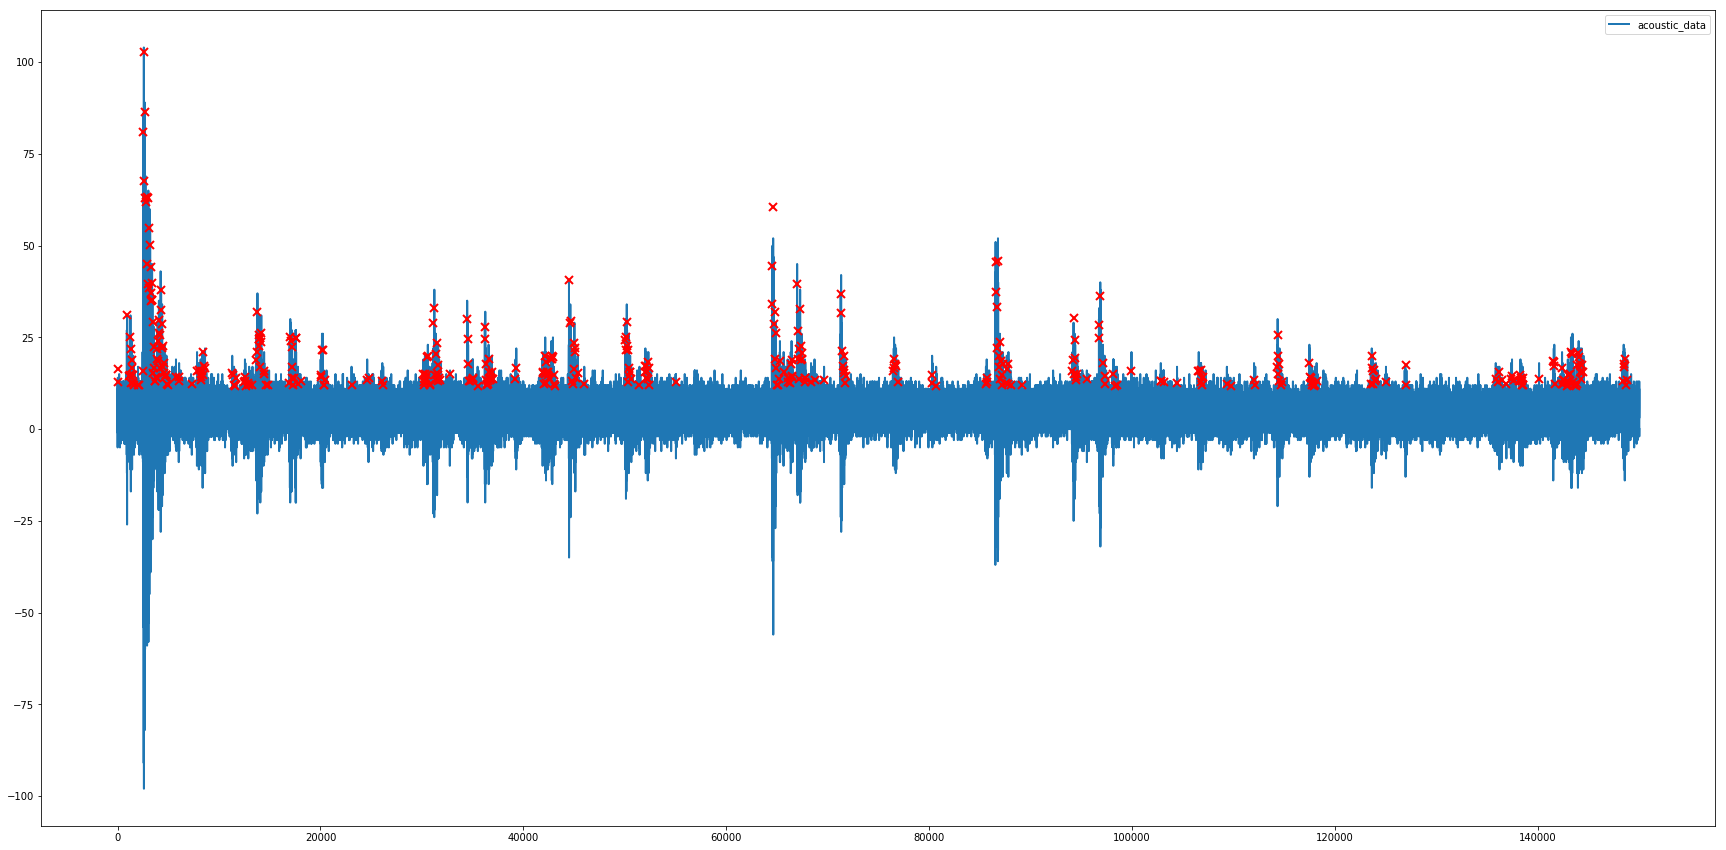

In [230]:
ax = train_df[:150_000].plot(y='acoustic_data', figsize=(30,15), linewidth=2)
ax.plot(proc_signal['px0'], proc_signal['height0'], "x", markersize=8, markeredgewidth=2, markeredgecolor='red', markerfacecolor='red')
#ax.plot(peaks_eq1_acs[0], 0, "x", markersize=18, markeredgewidth=2, markeredgecolor='red', markerfacecolor='red')
#ax.set_ylabel("Acoustic Signal")
#ax = ax.twinx()
#ax.plot(train_eq1['time_to_failure'], c='darkred')
#ax.set_ylabel("Time to Failure")
#ax.set_title("Figure-5: Delay between first acoustic_signal peak and zero time_to_failure")

In [340]:
# Ref https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

from scipy.stats import iqr,kurtosis,skew
from statistics import mode
from sklearn.decomposition import PCA


def create_features_peaks(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    xc = fft(xc)
    signal = process_signal(xc.ravel())
    px = signal[0]
    height = pd.Series(signal[1])
    f = signal[2]
    f0 = pd.Series(column(f, 0))
    f1 = pd.Series(column(f, 1))
    f2 = pd.Series(column(f, 2))
    f3 = pd.Series(column(f, 3))
    
# Common measures of location:    

    X.loc[seg_id, 'f0_mean'] = f0.mean()
    X.loc[seg_id, 'f0_median'] = f0.median()     
    X.loc[seg_id, 'f0_iqm'] = iqm(f0)
    
    X.loc[seg_id, 'f1_mean'] = f1.mean()
    X.loc[seg_id, 'f1_median'] = f1.median()     
    X.loc[seg_id, 'f1_iqm'] = iqm(f1)
    
    X.loc[seg_id, 'f2_mean'] = f2.mean()
    X.loc[seg_id, 'f2_median'] = f2.median()     
    X.loc[seg_id, 'f2_iqm'] = iqm(f2)
    
    X.loc[seg_id, 'f3_mean'] = f3.mean()
    X.loc[seg_id, 'f3_median'] = f3.median()     
    X.loc[seg_id, 'f3_iqm'] = iqm(f3)
    
    X.loc[seg_id, 'height_mean'] = height.mean()
    X.loc[seg_id, 'height_median'] = height.median()     
    X.loc[seg_id, 'height_iqm'] = iqm(height)
    X.loc[seg_id, 'height_sum'] = height.sum()
    X.loc[seg_id, 'height_max'] = height.max()
    X.loc[seg_id, 'height_min'] = height.min()
    
    X.loc[seg_id, 'px_count'] = len(px)
    
    
#Common measures of statistical dispersion:

    X.loc[seg_id, 'he_std'] = height.std()
    X.loc[seg_id, 'he_var'] = height.var()
    X.loc[seg_id, 'he_range'] = height.ptp()
    X.loc[seg_id, 'he_iqrange'] = iqr(height, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'he_mad'] = height.mad() 

    X.loc[seg_id, 'f0_std'] = f0.std()
    X.loc[seg_id, 'f0_var'] = f0.var()
    X.loc[seg_id, 'f0_range'] = f0.ptp()
    X.loc[seg_id, 'f0_iqrange'] = iqr(f0, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'f0_mad'] = f0.mad()   
    
    X.loc[seg_id, 'f1_std'] = f1.std()
    X.loc[seg_id, 'f1_var'] = f1.var()
    X.loc[seg_id, 'f1_range'] = f1.ptp()
    X.loc[seg_id, 'f1_iqrange'] = iqr(f1, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'f1_mad'] = f1.mad()  
    
    X.loc[seg_id, 'f2_std'] = f2.std()
    X.loc[seg_id, 'f2_var'] = f2.var()
    X.loc[seg_id, 'f2_range'] = f2.ptp()
    X.loc[seg_id, 'f2_iqrange'] = iqr(f2, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'f2_mad'] = f2.mad()  
    
    X.loc[seg_id, 'f3_std'] = f3.std()
    X.loc[seg_id, 'f3_var'] = f3.var()
    X.loc[seg_id, 'f3_range'] = f3.ptp()
    X.loc[seg_id, 'f3_iqrange'] = iqr(f3, rng=(25,75), interpolation='midpoint') 
    X.loc[seg_id, 'f3_mad'] = f3.mad() 
    
#Common measures of the shape:

    X.loc[seg_id, 'he_skew'] = skew(height)  
    X.loc[seg_id, 'he_kurtosis'] = kurtosis(height) 
    
    X.loc[seg_id, 'f0_skew'] = skew(f0)  
    X.loc[seg_id, 'f0_kurtosis'] = kurtosis(f0) 
    
    X.loc[seg_id, 'f1_skew'] = skew(f1)  
    X.loc[seg_id, 'f1_kurtosis'] = kurtosis(f1) 
        
    X.loc[seg_id, 'f2_skew'] = skew(f2)  
    X.loc[seg_id, 'f2_kurtosis'] = kurtosis(f2) 
    
    X.loc[seg_id, 'f3_skew'] = skew(f3)  
    X.loc[seg_id, 'f3_kurtosis'] = kurtosis(f3) 

In [341]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [342]:
from tqdm import tqdm_notebook

for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features_peaks(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

C:\Users\Tareq Mufaddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


In [343]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [344]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features_peaks(seg_id, seg, test_X)

C:\Users\Tareq Mufaddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


In [345]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [346]:
from sklearn.model_selection import KFold

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = train_X.columns.values

In [347]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.09868	valid_1's l1: 2.41163
[2000]	training's l1: 1.73393	valid_1's l1: 2.30707
[3000]	training's l1: 1.5084	valid_1's l1: 2.28656
[4000]	training's l1: 1.33261	valid_1's l1: 2.28248
Early stopping, best iteration is:
[3979]	training's l1: 1.33601	valid_1's l1: 2.28238
fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.09896	valid_1's l1: 2.38264
[2000]	training's l1: 1.73408	valid_1's l1: 2.27071
[3000]	training's l1: 1.50955	valid_1's l1: 2.24848
Early stopping, best iteration is:
[3367]	training's l1: 1.44133	valid_1's l1: 2.24557
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.10478	valid_1's l1: 2.42062
[2000]	training's l1: 1.74703	valid_1's l1: 2.27827
[3000]	training's l1: 1.52222	valid_1's l1: 2.25227
Early stopping, best iteration is:
[3541]	training's l1: 1.42172	valid_1's l1: 2.24899
fold 3
Tra

C:\Users\Tareq Mufaddi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


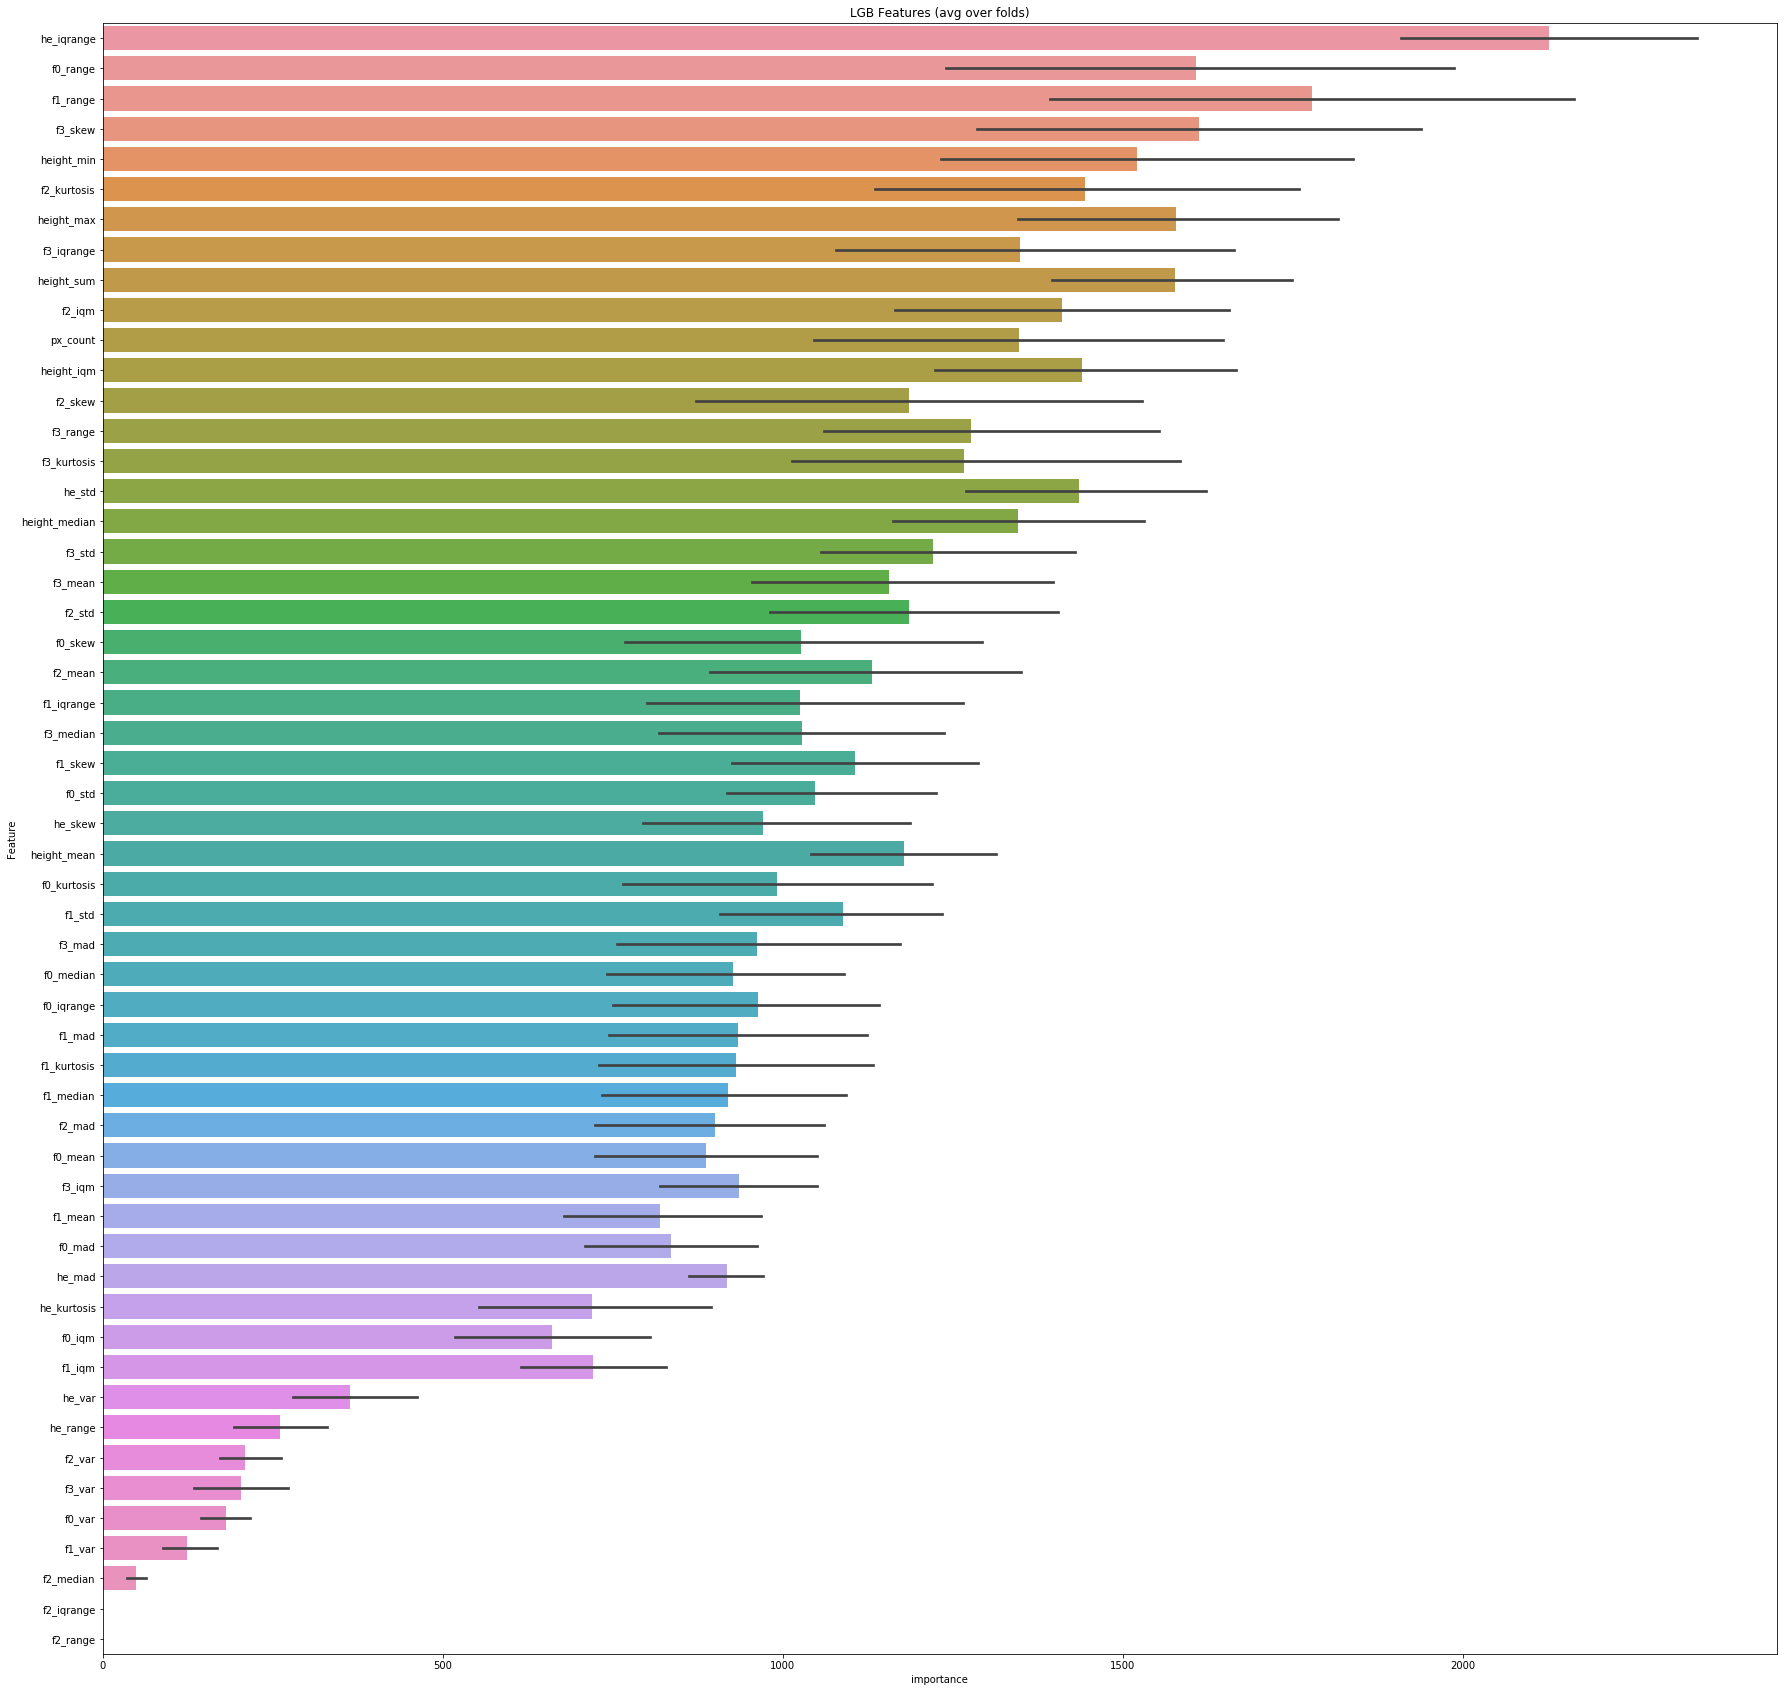

In [348]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import seaborn as sns

oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
scores = []
feature_importance_df = pd.DataFrame()
fold_importance = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    y_pred_valid = model.predict(X_val, num_iteration=model.best_iteration_)
    oof[val_idx] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_val, y_pred_valid))

    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits
    
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
feature_importance_df["importance"] /= fold_

cols = feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(
                by="importance", ascending=False)[:70].index

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(30, 30));
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [309]:
submission.time_to_failure = predictions
submission.to_csv('submission_peaks.csv',index=True)